<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Loading-Data" data-toc-modified-id="Loading-Data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Loading Data</a></span></li><li><span><a href="#Filtering" data-toc-modified-id="Filtering-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Filtering</a></span></li><li><span><a href="#Normalization" data-toc-modified-id="Normalization-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Normalization</a></span></li><li><span><a href="#Visualization" data-toc-modified-id="Visualization-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Visualization</a></span><ul class="toc-item"><li><span><a href="#PCA" data-toc-modified-id="PCA-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>PCA</a></span></li><li><span><a href="#UMAP" data-toc-modified-id="UMAP-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>UMAP</a></span></li></ul></li></ul></div>

In [1]:
import os 
import numpy as np
import pandas as pd
import pickle
from collections import defaultdict, Counter, OrderedDict

import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

import sklearn.manifold
from sklearn.decomposition import PCA

import phenograph

from scipy.sparse import csr_matrix, find, issparse

import warnings
warnings.filterwarnings("ignore")

import scanpy as scanpy
import time
import scipy
import umap

In [2]:
palette =  {0:"#000000",1:"#010067",2:"#D5FF00",3:"#FF0056",4:"#9E008E", 5:"#0E4CA1", 6:"#FFE502", 7:"#005F39", 8:"#00FF00", 9:"#95003A",10:"#FF937E",
          11:"#A42400", 12:"#001544", 13:"#91D0CB",14:"#620E00",15:"#6B6882",16:"#0000FF",17:"#007DB5",18:"#6A826C",19:"#00AE7E",20:"#C28C9F",
          21:"#BE9970",22:"#008F9C",23:"#5FAD4E",24:"#FF0000", 25:"#FF00F6",26:"#FF029D",27:"#683D3B",28:"#FF74A3",29:"#968AE8",30:"#98FF52",
          31:"#A75740",32:"#01FFFE",33:"#FFEEE8",34:"#FE8900",35:"#BDC6FF",36:"#01D0FF",37:"#BB8800",38:"#7544B1",39:"#A5FFD2",40:"#FFA6FE",
          41:"#774D00", 42:"#7A4782", 43:"#263400", 44:"#004754", 45:"#43002C", 46:"#B500FF", 47:"#FFB167", 48:"#FFDB66", 49:"#90FB92",
          50:"#7E2DD2", 51:"#BDD393", 52:"#E56FFE", 53:"#DEFF74", 54:"#00FF78", 55:"#009BFF", 56:"#006401", 57:"#0076FF", 58:"#85A900", 59:"#00B917",
          60:"#788231", 61:"#00FFC6", 62:"#FF6E41", 63:"#E85EBE"}
palette[70] = "#FFFFFF"

In [3]:
matplotlib.rcParams['figure.figsize'] = [2,2]
matplotlib.rcParams['figure.dpi'] = 150

# Loading Data

In [4]:
sample = ''

path_h5 = 'data/'
suffix_h5  = 'filtered_peak_bc_matrix.h5'

In [5]:
adata = scanpy.read_10x_h5(path_h5 + sample + "/" + suffix_h5, genome=None, gex_only=False)

In [6]:
peaks = np.array(adata.var['gene_ids'])
data = adata.X.copy()

In [7]:
sample_ids = np.array(list(adata.obs.index))
sample_ids = [sample.split("-")[1] for sample in sample_ids]

# Filtering

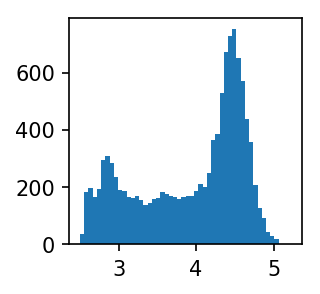

In [8]:
plt.hist(np.log10(data.sum(1)), bins = 50)
plt.show()

In [9]:
keep_cells = np.where(np.log10(data.sum(1))>4.1)[0]

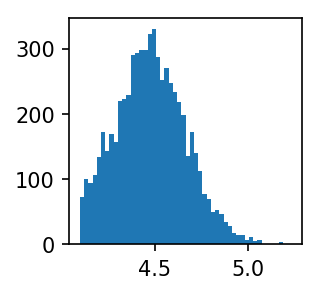

In [10]:
data = scipy.sparse.csr_matrix(data.toarray()[keep_cells,:])
data_bin = scipy.sparse.csr_matrix((data.toarray()>0.0).astype(np.int_))
sample_ids = np.array(sample_ids).astype(np.float32)[keep_cells]
plt.hist(np.log10(data.sum(1)), bins = 50);

# Normalization

In [11]:
coverage = np.array(data.sum(1))

In [12]:
model = sklearn.linear_model.LinearRegression(normalize=False,n_jobs = 10)
model = model.fit(X=coverage,y=data_bin.toarray())

In [13]:
start = [int(peak.split(":")[1].split("-")[0]) for peak in peaks]
stop = [int(peak.split(":")[1].split("-")[1]) for peak in peaks]
width = np.array(stop) - np.array(start) + 1
upper=2000
lower=2
keep = (width<upper) * (width>lower)

In [14]:
data_corrected = data_bin - model.predict(coverage) 
data_corrected = data_corrected[:,np.where(keep)[0]]

# Visualization

## PCA

In [15]:
pca = PCA(n_components=100)
pc = pca.fit_transform(data_corrected)

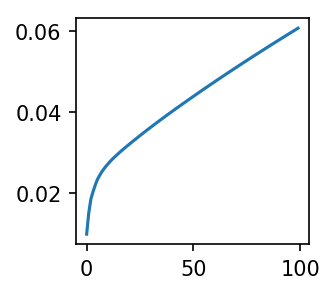

In [16]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))

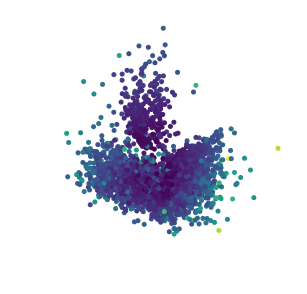

In [17]:
plt.scatter(pc[:,0],pc[:,1],s=2,c=coverage.flatten())
plt.axis("off");

## UMAP

In [18]:
#embedding = umap.UMAP(n_neighbors=30,min_dist=.3).fit_transform(pc[:,:20])
#to read in embedding from paper:
embedding = pd.read_csv("data/UMAP.csv").values

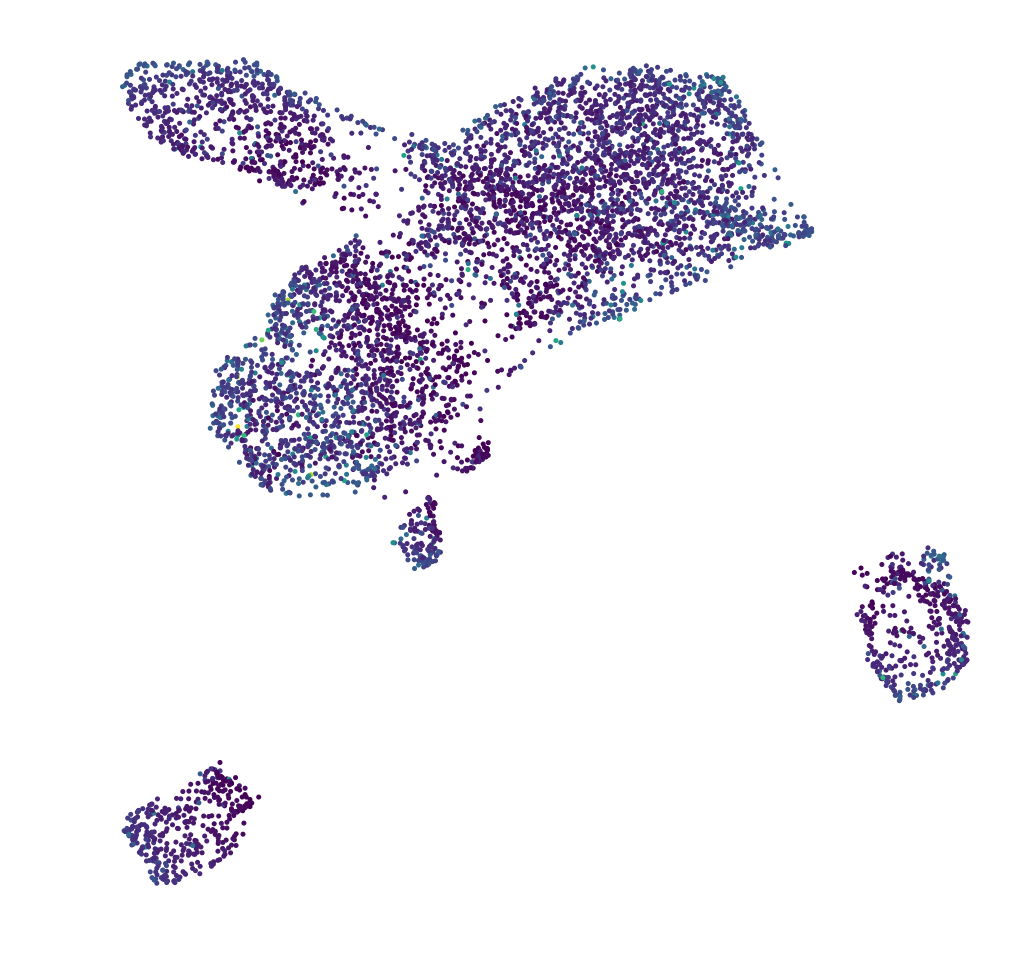

In [19]:
fig,ax = plt.subplots(figsize=(8,8))

ax.scatter(embedding[:,0],embedding[:,1], c=coverage.flatten() ,s=2,cmap='viridis')

ax.set_axis_off();

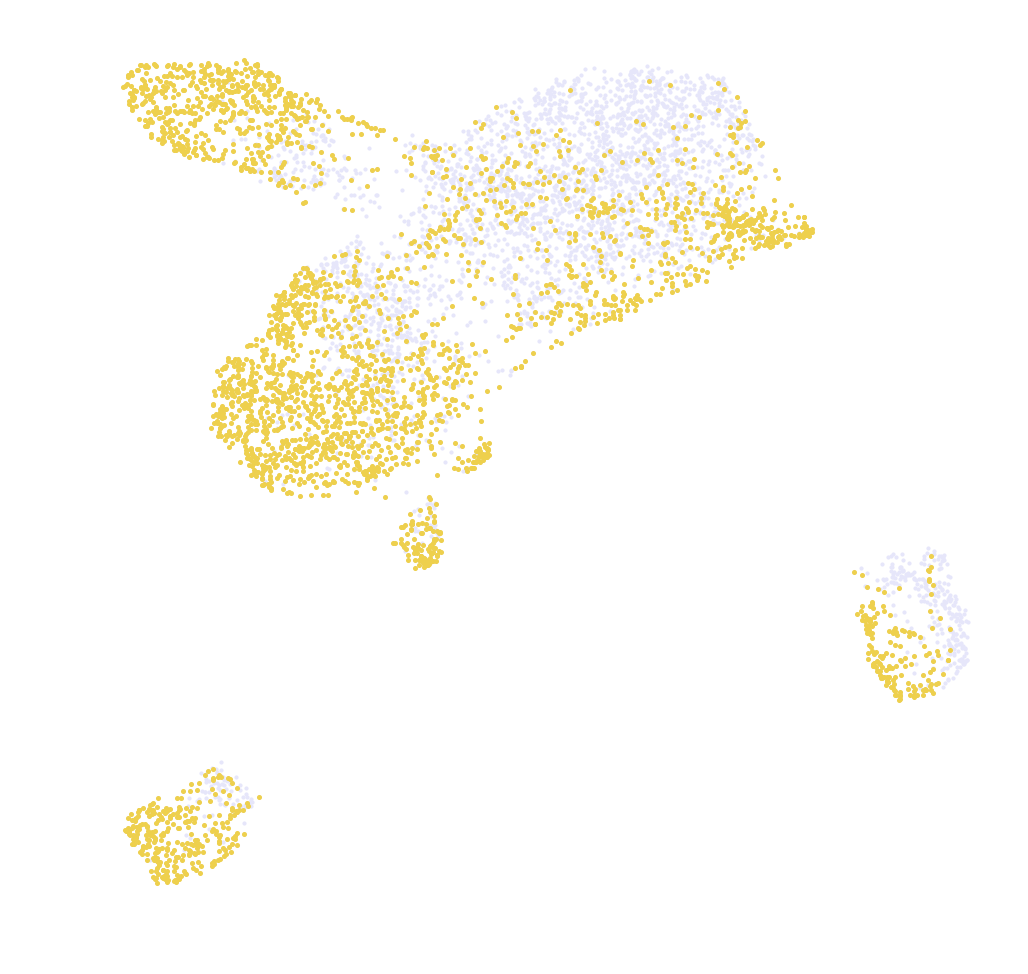

In [20]:
#PBS
fig,ax = plt.subplots(figsize=(8,8))

ax.scatter(embedding[:,0],embedding[:,1],s=1, c='lavender')
ax.scatter(embedding[:,0][sample_ids==2],embedding[:,1][sample_ids==2],s=2, c='#EED04D')

ax.set_axis_off();

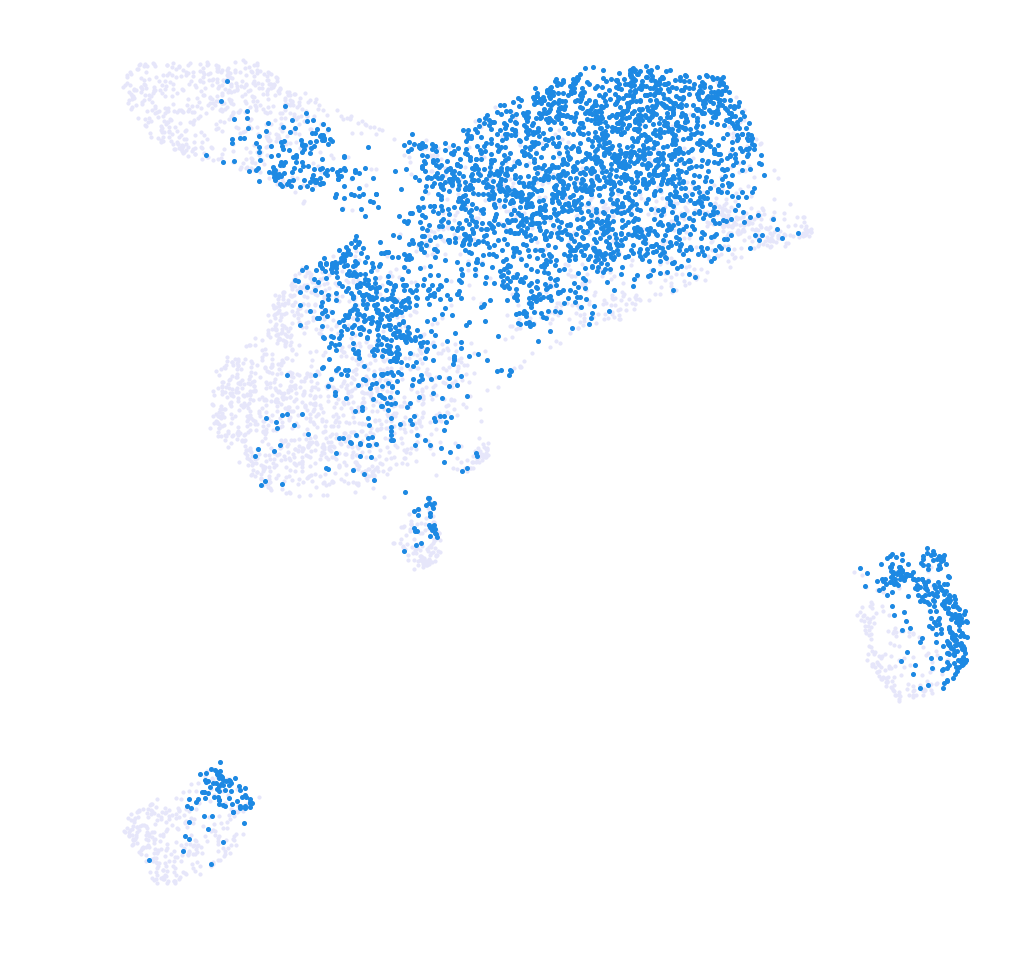

In [21]:
#injury
fig,ax = plt.subplots(figsize=(8,8))

ax.scatter(embedding[:,0],embedding[:,1],s=1, c='lavender')
ax.scatter(embedding[:,0][sample_ids==1],embedding[:,1][sample_ids==1],s=2, c="#1D89E3")

ax.set_axis_off();